In [52]:
import pandas as pd
from sklearn import tree, svm
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
import pickle
from dtree_skin_segmentation import RGB_TO_HSI, load_rgb_image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# model_loc is the location/name of the model you want to save
# and test
model_loc = "./Dataset/dtree_additional_images2.sav"

# old_model is the previous one that you want to visually compare against
old_model = "./Dataset/dtree_140_images.sav"

# set to true if you want to do training, False if testing
do_training = True

In [53]:
# list of csv files to be used as data to train model
dataset_files = [
    "./Dataset/pixelwise_skin_and_burn_trial.csv",
    "./Dataset/additional_data.csv",
    "./Dataset/additional_data2.csv"
]
# load initial dataset so that we have the structure
skin_dataset = pd.read_csv(dataset_files[0])

# append each additional dataset
for additional_file in dataset_files[1:]:
    additional_dataset = pd.read_csv(additional_file)
    skin_dataset = pd.concat([skin_dataset, additional_dataset], axis=0, ignore_index=True)

# remove na values so we don't get errors training and divide into
# input(X) and output(y)
skin_dataset = skin_dataset.dropna()
X = skin_dataset.iloc[:,:-1]
y = skin_dataset.iloc[:,-1]

In [54]:
# HSI can sometime have NaN as a 'H' value (need to debug)
# in the mean time we'll just keep an eye on them and ignore it
is_NaN = X.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = X[row_has_NaN]

Fold: 1
Dtree
Linear Regression
KNN
Fold: 2
Dtree
Linear Regression
KNN
Fold: 3
Dtree
Linear Regression
KNN
Fold: 4
Dtree
Linear Regression
KNN
Fold: 5
Dtree
Linear Regression
KNN


In [ ]:
if do_training:
    # score of each model at each fold
    model_scores = []
    # preserve the model for selection / save
    models = []
    fold_num = 0
    # using 5 fold cross validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X):
        # general setup, get train/test data subsets
        fold_num += 1
        print("Fold:", fold_num)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]# split()  method generate indices to split data into training and test set.

        # Train a decision tree classifier and track it's score
        print("Dtree")
        dtree = tree.DecisionTreeClassifier()
        dtree = dtree.fit(X_train.values, y_train.values)
        score1 = dtree.score(X_test.values, y_test.values)
        models.append(dtree)
        model_scores.append(score1)

        # Commented out for a while because it takes a long time
        # To train, uncomment if running on a machine powerful
        # enough or you're willing to give it enough time
        # print("SVC")
        # svm_model = svm.SVC(gamma='auto')
        # svm_model = svm_model.fit(X_train.values, y_train.values)
        # score2 = svm_model.score(X_test.values, y_test.values)
        # models.append(svm_model)
        # model_scores.append(score2)

        # try a liner regressor and keep track of that score as well
        print("Linear Regression")
        reg = LinearRegression().fit(X_train.values, y_train.values)
        score3 = reg.score(X_test.values, y_test.values)
        models.append(reg)
        model_scores.append(score3)

        # Try a knn classifier, it doesn't do quite as well
        # but pretty close. It could change if you add additional
        # data
        print("KNN")
        neigh = KNeighborsClassifier(n_neighbors=27)
        neigh = neigh.fit(X_train.values, y_train.values)
        score4 = neigh.score(X_test.values, y_test.values)
        models.append(neigh)
        model_scores.append(score4)

    # get the best model with the best score and save that
    max_value = max(model_scores)
    max_index = model_scores.index(max_value)
    pickle.dump(models[max_index], open(model_loc, 'wb'))
    #print(len(models))


In [57]:
# takes an image, model name, and confidence threshold and runs
# the model on each pixel of the image for classification
def image_masks(rgb_image, model_filename, aggression=0.9):
    # load the given pickled model from file
    loaded_model = pickle.load(open(model_filename, 'rb'))
    print("Loaded Model is:", model_loc)

    # create 3 arrays to hold classifications
    background = np.zeros(rgb_image.shape[:2])
    skin = np.zeros(rgb_image.shape[:2])
    burn = np.zeros(rgb_image.shape[:2])

    # models are using HSI as input so we do that conversion
    test_image_hsi = RGB_TO_HSI(rgb_image)

    # classify each pixel
    for row in range(0, test_image_hsi.shape[1]):
        for col in range(0, test_image_hsi.shape[0]):
            # if H value is NaN (bug to be solved) put it as
            # background to be conservative
            if np.isnan(test_image_hsi[row,col][0]):
                background[row,col] = 1
            # otherwise try to classify
            else:
                prediction = loaded_model.predict([test_image_hsi[row,col]])
                score = loaded_model.predict_proba([test_image_hsi[row,col]])
                # if predicted as healthy skin and is confident
                # enough, set the classification and next pixel
                if prediction == 1 and score[0][1] > aggression:
                    skin[row,col] = 1
                    #print("Skin Score:", score)
                # if predicted as burnt skin and is confident
                # enough, set the classification and next pixel
                elif prediction == 2 and score[0][2] > aggression:
                    burn[row,col] = 1
                    #print("Burn Score:", score)
                # Default is background if not confident in
                # the other classifications
                else:
                    background[row,col] = 1
    # return each mask individually so that we can run some image processing on it
    return background, skin, burn


In [58]:
# Dilate and erode is used on skin pixels because
# we've noticed that it gets the majority right, but
# NaN vlaues or proadic misclassifications can happen
# We want to fill in these small gaps without expanding
# The region
def dilate_and_erode(mask, erosion=4, dilation=2):
    img_dilation = cv2.dilate(mask,np.ones((3,3),
                            np.uint8),iterations=dilation)
    # blurred = cv2.GaussianBlur(img_dilation,(7,7),
    #                            cv2.BORDER_DEFAULT).astype('uint8')
    img_erosion = cv2.erode(img_dilation, np.ones((3,3),
                            np.uint8), iterations=erosion)
    return img_erosion

In [ ]:
# Erode and dilation is used for the background to
# get rid of any small misclassifications, background is
# the default at the moment, but further image processing
# could be done to combine the 3 masks in a more
# sophisticated way
def erode_and_dilation(mask, erosion=2, dilation=3):
    img_erosion = cv2.erode(mask,
                            np.ones((3,3), np.uint8), iterations=erosion)
    img_dilation = cv2.dilate(img_erosion,
                              np.ones((3,3), np.uint8),iterations=dilation)
    # blurred = cv2.GaussianBlur(img_dilation,(7,7),
    #                            cv2.BORDER_DEFAULT).astype('uint8')
    return img_dilation

In [59]:
# this is what the application calls. It takes
# rgb_image - the image to be segmented
# model_filename - the sklearn model to be used. Must be pixelwise
#     classification
# remove_background=False - Set to true if you want healthy/burned
#     skin pixels only
# burn_only=False - Set to true if you want only burnt skin pixels returned
# return_mask=False - Set to true if you'd like a matrix with class
#     labels in addition to the processed image. The class labels
#     are 0:background, 1:healthy skin, 2:burnt skin
# aggression=0.5 = The confidence required to be classified as skin
#     This is checked against the predict_proba of the classifier
# skin/burn dilation/erosion - The number of iterations of each
#     processing type on the image
def skin_overlay(rgb_image, model_filename, remove_background=False,
                 burn_only=False, return_mask=False, aggression=0.5,
                 skin_dilation=2, skin_erosion=4, burn_dilation=2,
                 burn_erosion=4):
    # create a copy so we're not editing the original image
    rgb_copy = rgb_image.copy()

    # get the 3 image masks (classes)
    background, skin, burn = image_masks(rgb_image,
                                         model_filename=model_filename,
                                         aggression=aggression)

    # apply image processing techniques to improve performance
    background_processed = erode_and_dilation(background)
    skin_processed = dilate_and_erode(skin, dilation=skin_dilation, erosion=skin_erosion)
    burn_processed = dilate_and_erode(burn, dilation=burn_dilation, erosion=burn_erosion)
    class_mask = np.zeros(rgb_image.shape[:2])
    img_copy = np.zeros(rgb_image.shape)

    #merge masks and return in the form the user desires
    for row in range(0,img_copy.shape[1]):
        for col in range(0,img_copy.shape[0]):
            if burn_processed[row,col] > 0:
                img_copy[row,col] = (255, 0, 0)
                class_mask[row,col] = 2
            elif skin_processed[row,col] > 0:
                img_copy[row,col] = (0, 255, 0)
                class_mask[row,col] = 1
                if burn_only:
                    rgb_copy[row,col] = (0, 0, 0)
            elif background_processed[row,col] > 0:
                img_copy[row,col] = (0, 0, 0)
                class_mask[row,col] = 0
                if remove_background or burn_only:
                    rgb_copy[row,col] = (0, 0, 0)
    if remove_background or burn_only:
        fused_img = rgb_copy
    else:
        img_copy_converted = img_copy.astype('uint8')
        fused_img = cv2.addWeighted(rgb_copy, 0.8, img_copy_converted, 0.2, 0)

    if return_mask:
        return fused_img, class_mask
    else:
        return fused_img

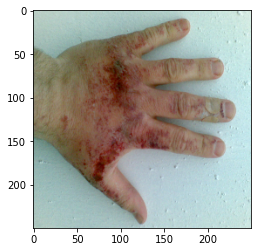

In [60]:
#EVERYTHING BELOW THIS IS FOR TESTING AND NOT RELATED TO FUNCTIONALITY

In [ ]:
test_img = "./Dataset/full_coco/images/img3.jpg"
rgb_image = load_rgb_image(test_img)
plt.imshow(rgb_image)

Loaded Model is: ./Dataset/dtree_additional_images2.sav


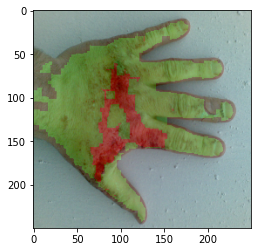

In [61]:
fused_img = skin_overlay(rgb_image, model_loc)
plt.imshow(fused_img)

Loaded Model is: ./Dataset/dtree_additional_images2.sav


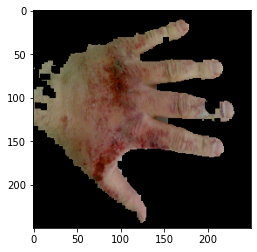

In [62]:
fused_img = skin_overlay(rgb_image, model_loc, remove_background=True)
plt.imshow(fused_img)

Loaded Model is: ./Dataset/dtree_additional_images2.sav


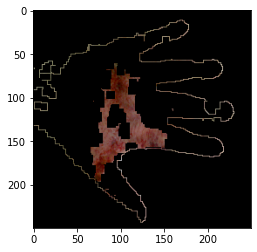

In [63]:
fused_img = skin_overlay(rgb_image, model_loc, remove_background=True, burn_only=True)
plt.imshow(fused_img)

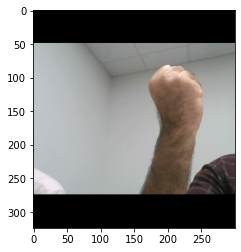

In [64]:
skin_img = './SkinOnlyExample.png'
skin_img_data = load_rgb_image(skin_img)
plt.imshow(skin_img_data)

Loaded Model is: ./Dataset/dtree_additional_images2.sav


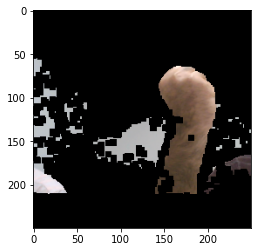

In [65]:
resized = cv2.resize(skin_img_data, (250, 250), interpolation = cv2.INTER_AREA)
processed_skin_img = skin_overlay(resized, model_loc, remove_background=True, aggression=0.5, skin_dilation=2, skin_erosion=4)
plt.imshow(processed_skin_img)